<a href="https://colab.research.google.com/github/Dworlock11/Exoplanet-Machine-Learning-Analysis/blob/main/Exoplanet_Habitability_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

This project intends to create useful machine learning models for predictive capabilities as well as draw insights from an exoplanet dataset. There will be two groups of models: one for predicting the type of exoplanet (Terran, Jovian, etc) and another for predicting the mass. Various models will be trained, tested, and evaluated and the best model from each group will be determined. Both the performance and the time necessary for training will be considered when determining the best models.

# Import Statements

In [477]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (make_scorer, classification_report, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error,
                             root_mean_squared_error)
from sklearn.exceptions import ConvergenceWarning
from sklearn.inspection import permutation_importance
from warnings import simplefilter

# Exploratory Data Analysis and Preprocessing

The data from an Excel sheet is read into a DataFrame. The number of columns will not be limited in order to display all features.

In [478]:
df = pd.read_excel("Exoplanet Catalog.xlsx")
pd.set_option('display.max_columns', None)
df

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,P_PERIOD,P_PERIOD_ERROR_MIN,P_PERIOD_ERROR_MAX,P_SEMI_MAJOR_AXIS,P_SEMI_MAJOR_AXIS_ERROR_MIN,P_SEMI_MAJOR_AXIS_ERROR_MAX,P_ECCENTRICITY,P_ECCENTRICITY_ERROR_MIN,P_ECCENTRICITY_ERROR_MAX,P_INCLINATION,P_INCLINATION_ERROR_MIN,P_INCLINATION_ERROR_MAX,P_OMEGA,P_OMEGA_ERROR_MIN,P_OMEGA_ERROR_MAX,P_TPERI,P_TPERI_ERROR_MIN,P_TPERI_ERROR_MAX,P_ANGULAR_DISTANCE,P_IMPACT_PARAMETER,P_IMPACT_PARAMETER_ERROR_MIN,P_IMPACT_PARAMETER_ERROR_MAX,P_TEMP_MEASURED,P_GEO_ALBEDO,P_GEO_ALBEDO_ERROR_MIN,P_GEO_ALBEDO_ERROR_MAX,P_DETECTION,P_DETECTION_MASS,P_DETECTION_RADIUS,P_ALT_NAMES,P_ATMOSPHERE,S_NAME,S_RA,S_DEC,S_MAG,S_DISTANCE,S_DISTANCE_ERROR_MIN,S_DISTANCE_ERROR_MAX,S_METALLICITY,S_METALLICITY_ERROR_MIN,S_METALLICITY_ERROR_MAX,S_MASS,S_MASS_ERROR_MIN,S_MASS_ERROR_MAX,S_RADIUS,S_RADIUS_ERROR_MIN,S_RADIUS_ERROR_MAX,S_TYPE,S_AGE,S_AGE_ERROR_MIN,S_AGE_ERROR_MAX,S_TEMPERATURE,S_TEMPERATURE_ERROR_MIN,S_TEMPERATURE_ERROR_MAX,S_DISC,S_MAGNETIC_FIELD,S_LOG_G,S_ALT_NAMES,P_ESCAPE,P_POTENTIAL,P_GRAVITY,P_DENSITY,P_HILL_SPHERE,P_DISTANCE,P_PERIASTRON,P_APASTRON,P_DISTANCE_EFF,P_FLUX,P_FLUX_MIN,P_FLUX_MAX,P_TEMP_EQUIL,P_TEMP_EQUIL_MIN,P_TEMP_EQUIL_MAX,P_TYPE,S_RADIUS_EST,S_TYPE_TEMP,S_RA_H,S_RA_T,S_DEC_T,S_LUMINOSITY,S_HZ_OPT_MIN,S_HZ_OPT_MAX,S_HZ_CON_MIN,S_HZ_CON_MAX,S_HZ_CON0_MIN,S_HZ_CON0_MAX,S_HZ_CON1_MIN,S_HZ_CON1_MAX,S_SNOW_LINE,S_ABIO_ZONE,S_TIDAL_LOCK,P_HABZONE_OPT,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007.0,2014-05-14,326.030000,-0.320,0.320,1.29000,-0.050,0.050,0.231,-0.005,0.005,NaN,NaN,NaN,94.8,-1.5,1.5,2452899.6,-1.6,1.6,13.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 Com,185.179280,17.792868,4.740,93.37,-1.92,1.92,-0.35,-0.09,0.09,2.70,-0.300,0.300,19.000000,-2.000,2.000,K0 III,NaN,NaN,NaN,4742.0,-100.0,100.0,NaN,NaN,2.31,"HD 107383, HIP 60202",NaN,NaN,NaN,NaN,0.130671,1.324418,0.99201,1.58799,1.298759,101.011410,64.855456,166.191940,799.44963,722.98875,914.73942,Jovian,19.000000,K,12.345286,12 20 43.0286,+17 47 34.3248,163.546800,10.132812,24.763411,12.834754,23.477907,13.586847,23.477907,12.390643,23.477907,34.529063,0.476460,0.642400,0.0,0.0,Hot,0.0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.863300,1.29000
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009.0,2018-09-06,516.219970,-3.200,3.200,1.53000,-0.070,0.070,0.080,-0.030,0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,11 UMi,229.274540,71.823898,5.016,125.72,-1.97,1.97,-0.02,NaN,NaN,2.78,-0.690,0.690,29.790000,-2.840,2.840,K4 III,NaN,NaN,NaN,4213.0,-46.0,46.0,NaN,NaN,1.93,"HD 136726, HIP 74793",NaN,NaN,NaN,NaN,0.167551,1.534896,1.40760,1.65240,1.531227,107.351180,91.741348,126.426170,819.07569,788.47184,854.28770,Jovian,29.790000,K,15.284970,15 17 05.8915,+71 49 26.0328,250.492940,12.770059,31.984271,16.175280,30.323783,17.134143,30.323783,15.615215,30.323783,42.732816,0.193891,0.648683,0.0,0.0,Hot,0.0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.784800,1.53000
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008.0,2014-05-14,185.840000,-0.230,0.230,0.83000,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2452861.4,-1.5,1.5,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Radial Velocity,NaN,NaN,NaN,NaN,14 And,352.822570,39.236198,5.227,75.59,-0.71,0.71,-0.24,-0.03,0.03,2.20,-0.200,0.100,11.000000,-1.000,1.000,G8 III,NaN,NaN,NaN,4813.0,-20.0,20.0,NaN,NaN,2.63,"HD 221345, HIP 116076",NaN,NaN,NaN,NaN,0.073485,0.830000,0.83000,0.83000,0.830000,84.446427,84.446427,84.446427,772.30746,772.30746,772.30746,Jovian,11.000000,G,23.521506,23 31 17.4215,+39 14 10.3128,58.175144,6.025230,14.680087,7.631867,13.918028,8.078404,13.918028,7.367780,13.918028,20.593611,0.502752,0.600010,0.0,0.0,Hot,0.0,0.081917,Andromeda,And,And

Before the data can be used for model development, it needs to be cleaned and analyzed. The current shape is saved to compare later.

In [479]:
original_shape = df.shape

As many of the columns from the dataset contain a lot of null entries, it is best to simply remove the columns. All columns with more null values than a quarter of the length of the dataset are removed.

In [480]:
col_non_null_count = df.isna().sum()
cols_non_majority_null = col_non_null_count[col_non_null_count < len(df)/4].index.to_list()
df = df[cols_non_majority_null]

Additional feature selection is conducted, as many of the features are unhelpful for model training, are copies of one another, or are highly correlated.

In [481]:
df = df.drop(["P_NAME", "P_STATUS", "P_RADIUS", "P_YEAR", "P_UPDATED", "S_NAME", "S_RADIUS", "S_ALT_NAMES", "P_HABZONE_OPT", "P_HABZONE_CON", "S_CONSTELLATION_ABR", "P_PERIOD_ERROR_MIN", "P_PERIOD_ERROR_MAX", "S_DISTANCE_ERROR_MIN", "S_DISTANCE_ERROR_MAX", "P_FLUX_MIN", "P_FLUX_MAX", "P_TEMP_EQUIL_MIN", "P_TEMP_EQUIL_MAX"], axis=1)

Categorical features with far too many unique values are removed to simplify feature encoding.

In [482]:
cat_features = df.select_dtypes(exclude=np.number)

for col in cat_features.columns:
  print(col, "-", len(cat_features[col].value_counts()))

df = df.drop(["S_RA_T", "S_DEC_T", "S_CONSTELLATION", "S_CONSTELLATION_ENG"], axis=1)

P_DETECTION - 10
P_TYPE - 6
S_TYPE_TEMP - 7
S_RA_T - 3010
S_DEC_T - 3010
P_TYPE_TEMP - 3
S_CONSTELLATION - 88
S_CONSTELLATION_ENG - 88


The data is checked for the skew of each feature to determine the appropriate imputing method for numerical data.

In [483]:
np.abs(df.skew(axis=0, numeric_only=True, skipna=True)).sort_values(ascending=False)

,0
P_PERIOD,62.170001
P_FLUX,45.699102
S_MASS_ERROR_MAX,45.649624
S_ABIO_ZONE,39.242821
S_RADIUS_ERROR_MIN,32.113850
S_RADIUS_ERROR_MAX,31.053663
P_PERIASTRON,28.463444
P_SEMI_MAJOR_AXIS_EST,28.395487
P_DISTANCE_EFF,28.376942
P_DISTANCE,28.337572


Since the data is heavily skewed, the median will be chosen.

The distribution of exoplanet type is observed.

In [484]:
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,58
Miniterran,1


A single Miniterran planet can't be split amongst a training and test set. According to the official classification practice of exoplanets, Miniterrans have a radius between 0.03 and 0.04 times that of Earth. Subterrans have a radius between 0.4 and 0.8 times that of Earth. If the Miniterran in the data has a radius close to that of Subterrans, it would be appropriate to mask it as one.

In [485]:
miniterran = df[df["P_TYPE"] == "Miniterran"]
miniterran["P_RADIUS_EST"]

,P_RADIUS_EST
3770,0.333946


Indeed, the radius is around 0.33 times that of Earth, which isn't too far from the 0.4 minimum for a Subterran. Therefore, the planet is masked as one.

In [486]:
df["P_TYPE"] = df["P_TYPE"].mask(df["P_TYPE"] == "Miniterran", "Subterran")
df["P_TYPE"].value_counts()

,count
P_TYPE,
Jovian,1302
Superterran,1099
Neptunian,898
Terran,673
Subterran,59


Now, the distribution of the mass is observed.

In [487]:
df["P_MASS_EST"].describe()

,P_MASS_EST
count,4048.000000
mean,323.089993
std,965.084290
min,0.000000
25%,3.628101
50%,7.815324
75%,149.379160
max,17668.059000


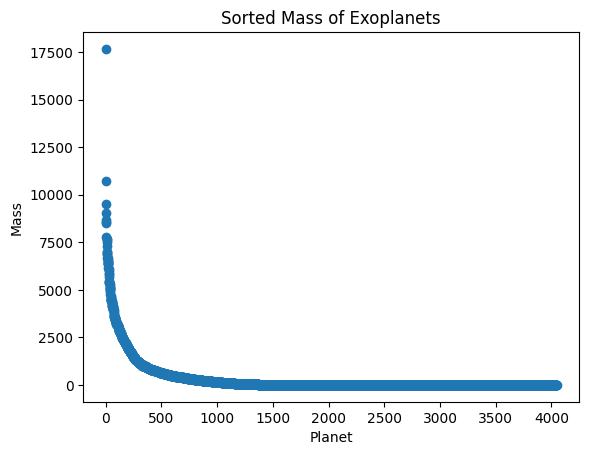

In [488]:
plt.scatter(x=range(0, len(df.index)), y=df["P_MASS_EST"].sort_values(ascending=False))
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Sorted Mass of Exoplanets")
plt.show()

From this distribution, a couple of points should be made.


*   The majority of planets seem to be approximately eight times the mass of the Earth. A minority are singificantly larger. There will almost certainly be a significant difference between the RMSE and the MAE when evaluating the models, since RMSE is more sensitive to outliers.
*   Because the smallest planets and the largest are orders of magnitude apart, it would make sense to tranform the mass into log space.
*   Huber loss will be used for hyperparameter training and permutation to balance the majority of small planets with the minority of enormous ones.
*   It's not clear what exactly it means for a planet to have a mass of 0.0. It might be a mistake. Such entries will be removed to be safe.

In [489]:
df = df[df["P_MASS_EST"] != 0.0]

Here's the shape of the cleaned DataFrame.

In [490]:
new_shape = df.shape
print("Original shape:", original_shape)
print("New shape:", new_shape)

# Exoplanet Type Classification

The classification models will be trained first, starting with logistic regression.

## Logistic Regression

All rows where the target value is null are removed to prevent errors.

In [491]:
print("Number of null values:", df["P_TYPE"].isna().sum())
y_na = df[df["P_TYPE"].isna()].index
df = df.drop(y_na)
print("Number of null values after removal:", df["P_TYPE"].isna().sum())

Number of null values: 1
Number of null values after removal: 0


The data is separated into the features and the target.

In [492]:
X = df.drop("P_TYPE", axis=1)
y = df["P_TYPE"]

The data is split into the training and testing data. It is stratified by the exoplanet type to make sure that a proportional number of each type is present in both the training set and the test set.

In [493]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=9)

The data preprocessor is created, including data imputing, standardizing, and encoding.

In [494]:
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

ohe_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", feature_name_combiner="concat"))
])

log_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and the hyperparameter C is tuned to prevent overfitting.

In [495]:
log_pipe = Pipeline([
    ("log_preprocessor", log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}

search = RandomizedSearchCV(log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is now trained and the tuned values for each hyperparameter are displayed.

In [496]:
simplefilter("ignore", category=ConvergenceWarning)

search.fit(X_train, y_train)
best_model = search.best_estimator_
print("C:", f"{search.best_params_['log_reg__C']:.3f}")

C: 372.759


The model is tested and evaluated.

In [497]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.97      0.98       260
   Neptunian       0.94      0.94      0.94       180
   Subterran       0.58      0.58      0.58        12
 Superterran       0.96      0.97      0.96       220
      Terran       0.94      0.94      0.94       135

    accuracy                           0.95       807
   macro avg       0.88      0.88      0.88       807
weighted avg       0.95      0.95      0.95       807



The model performs very well overall. Interestingly, Subterrans performed significantly worse than the other types, likely due to a significantly smaller number of entries.

A confusion matrix illustrates these findings.

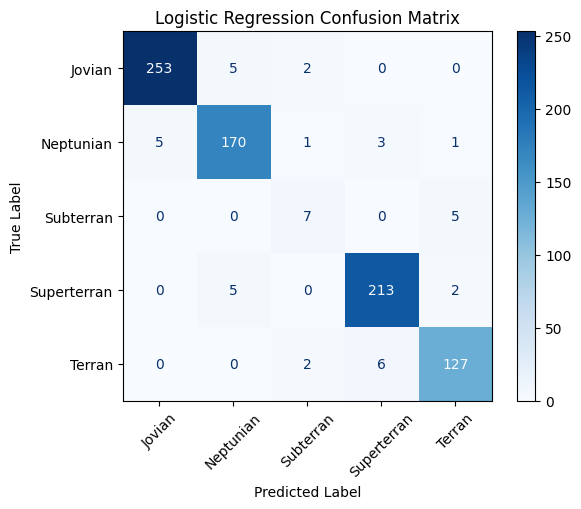

In [498]:
class_labels = ["Jovian", "Neptunian", "Subterran", "Superterran", "Terran"]
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

Permutation is used to find the importance of the individual features. It will be used across all models for standardized results. The test set must be manually transformed with all preprocessing steps before implementing permutation to match the number of columns present in the model.

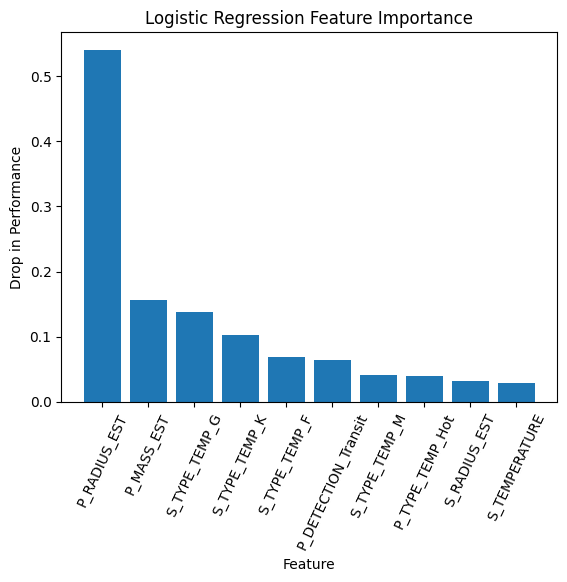

In [499]:
# Extract components
preprocessor = best_model.named_steps["log_preprocessor"]
log_reg = best_model.named_steps["log_reg"]

raw_feature_names = preprocessor.get_feature_names_out()
# Remove transformer names from text
clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance
importances = permutation_importance(log_reg, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

Apparently, the most important feature for predicting the type of the planet is its radius. This make sense, as the classification of a planet is based on the planet's radius compared to Earth's.

## Polynomial Logistic Regression

Now polynomial features will be added to see if there will be a significant difference.

A new preprocessor is created to accomdate polynomial features.

In [500]:
# Build transformers
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler())
])

# Combine transformers
poly_log_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [501]:
poly_log_pipe = Pipeline([
    ("poly_log_preprocessor", poly_log_preprocessor),
    ("log_reg", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        max_iter=300
    ))
])

param_dist = {
    "log_reg__C": np.logspace(-3, 3, 15),
}

search = RandomizedSearchCV(poly_log_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is again trained and optimal regularization strength is shown.

In [502]:
# simplefilter("ignore", category=ConvergenceWarning)

# search.fit(X_train, y_train)
# best_model = search.best_estimator_
# print("C:", f"{search.best_params_['log_reg__C']:.3f}")

The model is tested and evaluated.

In [503]:
# y_pred = best_model.predict(X_test)
# print(classification_report(y_test, y_pred))

In [504]:
# cm = confusion_matrix(y_test, y_pred, labels=class_labels)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
# disp.plot(cmap=plt.cm.Blues)
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title('Logistic Regression Confusion Matrix')
# plt.xticks(rotation=45)
# plt.show()

The model performs around the same as without polynomial features. However, the time necesary to fit is significantly longer. Therefore, there seems to be little reason to include polynomial features.

Feature importance is ignored, as most of the features are simply engineered polynomial features, giving little legitimate insight.

## Decision Tree

Now, a decision tree model will be trained following the same process.

A new categorical transformer is created using ordinal encoding, which is suitable for tree-based models and better than one-hot encoding, since it doesn't create many additional features.

In [505]:
tree_cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Combine transformers
tree_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("tree_cat_transformer", tree_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented, testing values for the major hyperparameters of decision trees.

In [506]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeClassifier())
])

param_dist = {
    "dec_tree__max_depth": [None, 2, 5, 10, 20],
    "dec_tree__min_samples_split": [2, 5, 10, 20, 50],
    "dec_tree__min_samples_leaf": [1, 2, 5, 10, 20],
    "dec_tree__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained and optimized hyperparameters are shown.

In [507]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

min_samples_split : 20
min_samples_leaf : 2
max_features : None
max_depth : 20


The model is tested and evaluated.

In [508]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      Jovian       0.98      0.99      0.99       260
   Neptunian       0.98      0.97      0.97       180
   Subterran       1.00      1.00      1.00        12
 Superterran       1.00      1.00      1.00       220
      Terran       1.00      1.00      1.00       135

    accuracy                           0.99       807
   macro avg       0.99      0.99      0.99       807
weighted avg       0.99      0.99      0.99       807



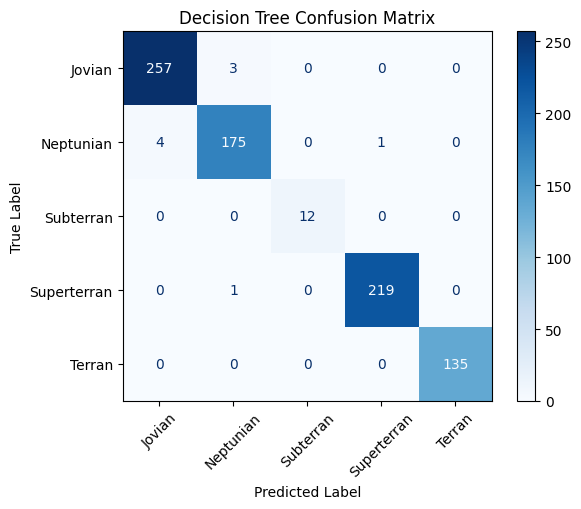

In [509]:
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

The metrics are notably better than those from the logistic regression model, especially for Subterrans. Perhaps decision trees are better suited for multiclass classification.

Permutation is once again used to discover feature importance.

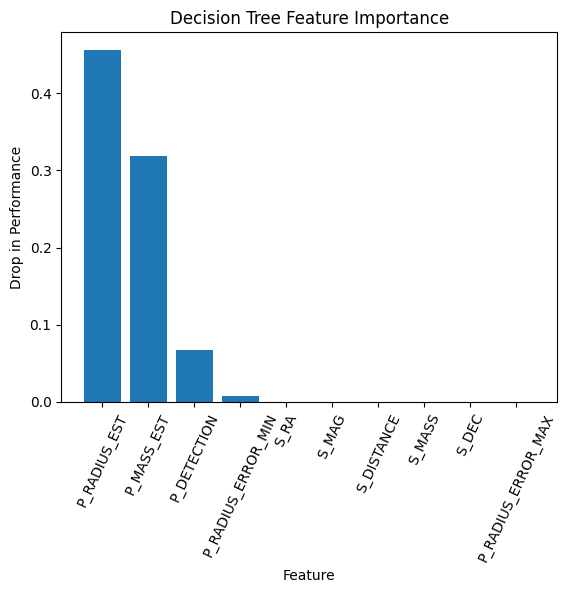

In [510]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
dec_tree = best_model.named_steps["dec_tree"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()
clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Calculate importances
importances = permutation_importance(dec_tree, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

In comparison to the logistic regression model, P_MASS_EST has more significance for prediction.

## Random Forest

Now, a random forest model will be trained.

The pipeline is created and hyperparameter tuning is implemented, testing ranges of values for the major hyperparameters.

In [511]:
forest_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("rand_for", RandomForestClassifier())
])

param_dist = {
    "rand_for__n_estimators": [200, 400, 600, 800],
    "rand_for__max_depth": [None, 5, 10, 20, 40],
    "rand_for__min_samples_split": [2, 5, 10, 20],
    "rand_for__min_samples_leaf": [1, 2, 5, 10],
    "rand_for__max_features": ["sqrt", "log2", None],
    "rand_for__bootstrap": [True, False],
}

search = RandomizedSearchCV(forest_pipe, param_distributions=param_dist, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained and hyperparameter values are shown.

In [512]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param.split("__", 1)[1], ":" , value)

n_estimators : 600
min_samples_split : 5
min_samples_leaf : 2
max_features : None
max_depth : 40
bootstrap : True


The model is tested and evaluated.

In [513]:
y_pred = best_model.predict(X_test)
classification_report(y_test, y_pred)

              precision    recall  f1-score   support

      Jovian       0.98      0.99      0.99       260
   Neptunian       0.98      0.97      0.98       180
   Subterran       1.00      1.00      1.00        12
 Superterran       1.00      1.00      1.00       220
      Terran       1.00      1.00      1.00       135

    accuracy                           0.99       807
   macro avg       0.99      0.99      0.99       807
weighted avg       0.99      0.99      0.99       807



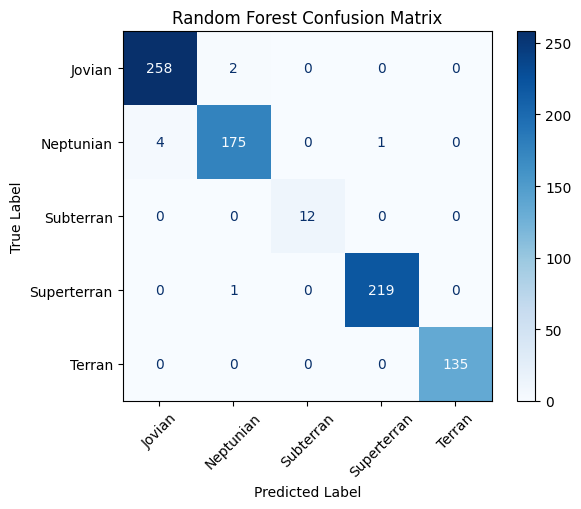

In [514]:
cm = confusion_matrix(y_test, y_pred, labels=class_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.xticks(rotation=45)
plt.show()

The metrics are around the same as those for the decision tree model. However, it takes much longer to fit, making random forests apparently unnecessary for this task.

Permutation is once again used to discover feature importance.

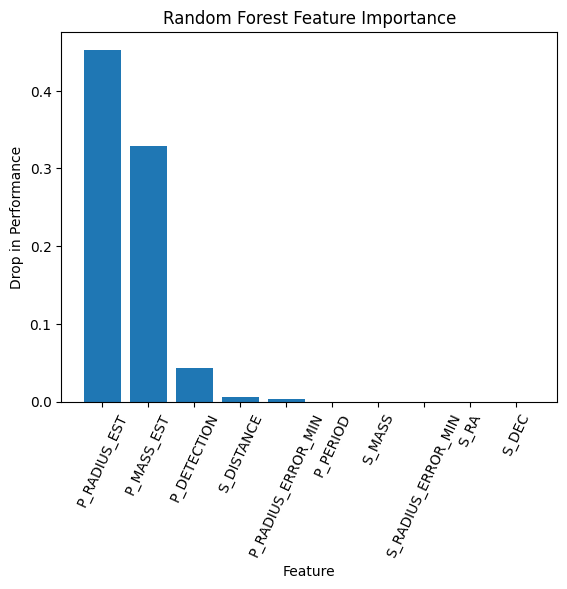

In [515]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
rand_for = best_model.named_steps["rand_for"]

# Run permutation importance
importances = permutation_importance(rand_for, X_test_transformed, y_test, n_repeats=10, random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=70)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

The results are similar to those from the decision tree model.

# Exoplanet Mass Prediction

Now, regression models will be created to predict exoplanet mass.

## Ridge Regression

Now, the mass of planets will be predicted using various models, starting with Ridge regression. Ridge is chosen over standard linear regression to enable regularization.

As mentioned earlier, P_MASS_EST is transformed to be in log space.

In [516]:
log_df = df.copy()
log_df["Log_Mass"] = np.log10(log_df["P_MASS_EST"])
log_df = log_df.drop("P_MASS_EST", axis=1)

The data is split into the features and the target.

In [517]:
X = log_df.drop("Log_Mass", axis=1)
y = log_df["Log_Mass"]

All rows where the target value is null are removed.

In [518]:
y_na = y[y.isna()]
data = X.join(y)
data = data.drop(y_na.index)
X = data.drop("Log_Mass", axis=1)
y = data["Log_Mass"]
print(y.isna().sum())

0


The data is split into the training and testing data.

In [519]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

Transformers for numerical and categorical data are created.

In [520]:
# Separate numerical and categorical features
num_features = X_train.select_dtypes(include=np.number)
cat_features = X_train.select_dtypes(exclude=np.number)
num_col_names = num_features.columns
cat_col_names = cat_features.columns

# Combine transformers
ridge_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

The pipeline is created and hyperparameter tuning is implemented.

In [521]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)

    quadratic = np.minimum(abs_error, delta)
    linear = abs_error - quadratic

    return np.mean(0.5 * quadratic**2 + delta * linear)

huber_scorer = make_scorer(huber_loss, greater_is_better=False, delta=1.0)

In [522]:
ridge_pipe = Pipeline([
    ("ridge_preprocessor", ridge_preprocessor),
    ("ridge", Ridge())
])

kf = KFold(n_splits=5, shuffle=True, random_state=9)

param_dist = {
    "ridge__alpha": np.logspace(-4, 4)
}

search = RandomizedSearchCV(ridge_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf,
                            random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [523]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

ridge__alpha : 1526.4179671752302


In [524]:
y_pred_se = pd.Series(y_pred)
y_pred_se.describe()

,0
count,807.000000
mean,1.562995
std,7.763020
min,0.260055
25%,0.719682
50%,0.946642
75%,2.010783
max,220.658874


In [525]:
y_test_se = y_test.reset_index(drop=True)
y_test_se.describe()

,Log_Mass
count,807.000000
mean,1.260273
std,1.007618
min,-1.719657
25%,0.578587
50%,0.874435
75%,2.090880
max,3.884029


The MAE is used to evaluate the model.

In [526]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

MAE factor  : 3.66×
RMSE factor : 45010330.47×


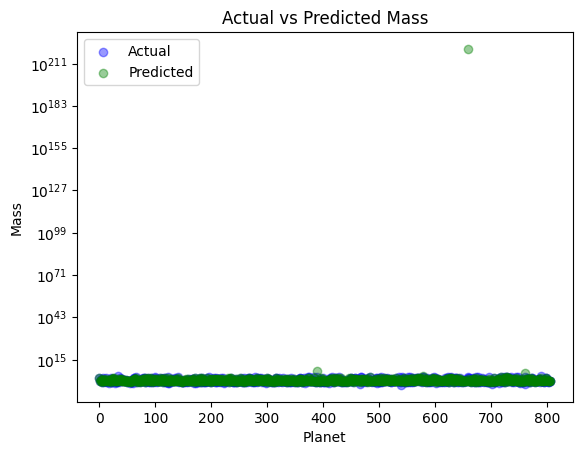

In [527]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

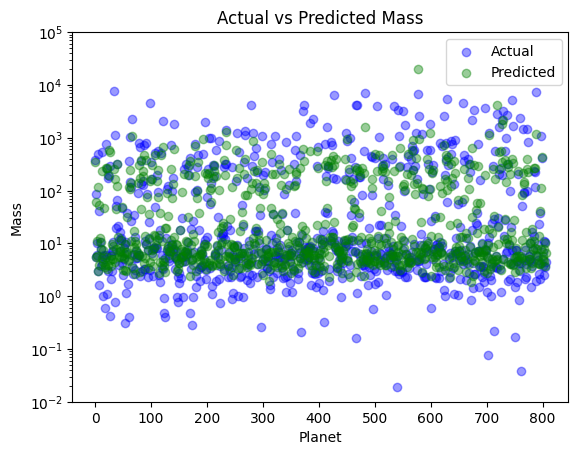

In [528]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.ylim(0.01, 100000)
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

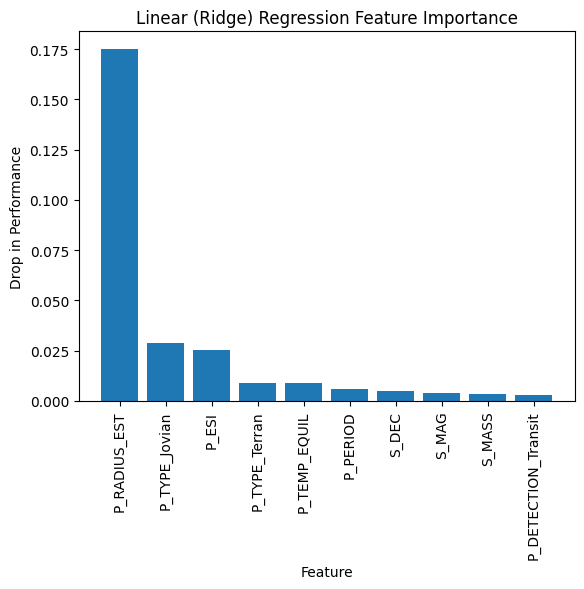

In [529]:
# Extract components
preprocessor = best_model.named_steps["ridge_preprocessor"]
ridge = best_model.named_steps["ridge"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(ridge, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Linear (Ridge) Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

## Polynomial Ridge Regression

The output from Ridge will be compared to its output with polynomial features.

The pipeline is created and hyperparameter tuning is implemented.

In [530]:
poly_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler())
])

poly_ridge_preprocessor = ColumnTransformer([
    ("poly_transformer", poly_transformer, num_col_names),
    ("ohe_cat_transformer", ohe_cat_transformer, cat_col_names)
])

In [531]:
poly_ridge_pipe = Pipeline([
    ("poly_ridge_preprocessor", poly_ridge_preprocessor),
    ("ridge", Ridge())
])

param_dist = {
    "poly_ridge_preprocessor__poly_transformer__poly__degree" : [2, 3],
    "ridge__alpha" : np.logspace(-4, 4)
}

search = RandomizedSearchCV(poly_ridge_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf,
                            random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [532]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

KeyboardInterrupt: 

In [ ]:
y_pred_se = pd.Series(y_pred)
y_pred_se.describe()

In [ ]:
y_test_se.describe()

The MAE and R-squared scores are used to evaluate the model.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

In [ ]:
plt.scatter(x=range(0, len(y_test)), y=10**y_test.reset_index(drop=True), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

In [ ]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.ylim(0.01, 100000)
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

In [ ]:
# Extract components
preprocessor = best_model.named_steps["poly_ridge_preprocessor"]
ridge = best_model.named_steps["ridge"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(ridge, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Polynomial (Ridge) Regression Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

## Decision Tree Regressor

In [ ]:
tree_preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, num_col_names),
    ("tree_cat_transformer", tree_cat_transformer, cat_col_names)
])

tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("dec_tree", DecisionTreeRegressor())
])

param_dist = {
    "dec_tree__max_depth": [None, 3, 5, 10, 20],
    "dec_tree__min_samples_split": [2, 5, 10, 20, 50],
    "dec_tree__min_samples_leaf": [1, 2, 5, 10, 20, 50],
    "dec_tree__max_features": [None, "sqrt", "log2"]
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [ ]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

In [ ]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

The MAE is used to evaluate the model.

In [ ]:
# Extract components
preprocessor = best_model.named_steps["tree_preprocessor"]
dec_tree = best_model.named_steps["dec_tree"]

# Remove name of transformer from each feature
raw_feature_names = preprocessor.get_feature_names_out()

clean_feature_names = [
    name.split("__", 1)[1] if "__" in name else name
    for name in raw_feature_names
]

# Transform X_test into expanded feature space
X_test_transformed = preprocessor.transform(X_test)

# Run permutation importance on the classifier only
importances = permutation_importance(dec_tree, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Decision Tree Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

The model performs reasonably well across all metrics.

## Random Forest Regressor

The pipeline is created and hyperparameter tuning is implemented.

In [ ]:
tree_pipe = Pipeline([
    ("tree_preprocessor", tree_preprocessor),
    ("rand_for", RandomForestRegressor())
])

param_dist = {
    "rand_for__n_estimators": [200, 300, 500, 800],
    "rand_for__max_depth": [None, 5, 10, 20, 40],
    "rand_for__min_samples_split": [2, 5, 10, 20],
    "rand_for__min_samples_leaf": [1, 2, 5, 10, 20],
    "rand_for__max_features": ["sqrt", "log2", None],
    "rand_for__bootstrap": [True, False]
}

search = RandomizedSearchCV(tree_pipe, param_distributions=param_dist, scoring=huber_scorer, n_iter=10, cv=kf, random_state=9, n_jobs=-1)

The model is trained, tested, and scored with a classification report.

In [ ]:
search.fit(X_train, y_train)
best_model = search.best_estimator_
for param, value in search.best_params_.items():
  print(param,":", value)

y_pred = best_model.predict(X_test)

The MAE is used to evaluate the model.

In [ ]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE factor  : {10**mae:.2f}×")
print(f"RMSE factor : {10**rmse:.2f}×")

In [ ]:
plt.scatter(x=range(0, len(y_test)), y=10**(y_test.reset_index(drop=True)), color="blue", alpha=0.4, label="Actual")
plt.scatter(x=range(0, len(y_pred)), y=10**y_pred, color="green", alpha=0.4, label="Predicted")
plt.yscale("log")
plt.legend()
plt.xlabel("Planet")
plt.ylabel("Mass")
plt.title("Actual vs Predicted Mass")
plt.show()

In [ ]:
# Extract components
rand_for = best_model.named_steps["rand_for"]

# Run permutation importance on the classifier only
importances = permutation_importance(rand_for, X_test_transformed, y_test, scoring=huber_scorer, n_repeats=10,
                                     random_state=9, n_jobs=-1)

# Display results
highest_importances = pd.Series(importances.importances_mean, index=clean_feature_names).sort_values(ascending=False).head(10)
plt.bar(highest_importances.index, highest_importances)
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Drop in Performance")
plt.show()

The model performs reasonably well across all metrics.

# Conclusion